In [13]:
import os
import subprocess
import re
import pandas as pd
from pathlib import Path
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
DSSR_BIN = "/Users/massimodellepiane/Developer/dssr-basic-macOS-v2.5.2/x3dna-dssr"

In [15]:
def run_dssr(pdb_path):
    result = subprocess.run(
        [DSSR_BIN, f"--input={pdb_path}", "--more"],
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True,
    )
    if result.returncode != 0:
        raise RuntimeError(f"DSSR failed on {pdb_path}: {result.stderr}")
    return result.stdout

In [16]:
def parse_dssr_helix_data(dssr_out):
    helix_info = {
        "num_bp": 0,
        "num_WC": 0,
        "num_nonWC": 0,
        "helical_rise": None,
        "rise_sd": None,
        "helical_radius": None,
        "radius_sd": None,
        "avg_twist": None,
        "spatial_length": None,
        "avg_shift": None,
        "avg_slide": None,
        "avg_rise_step": None,
        "avg_tilt": None,
        "avg_roll": None,
        "avg_twist_step": None,
    }

    # Match number of base pairs
    helix_header_match = re.search(r"helix#\d+\[\d+\] bps=(\d+)", dssr_out)
    if not helix_header_match:
        return helix_info
    helix_info["num_bp"] = int(helix_header_match.group(1))

    # WC and non-WC base pairs
    bp_type_match = re.search(r"bp-type\s+([|.]+)", dssr_out)
    if bp_type_match:
        bp_symbols = bp_type_match.group(1)
        helix_info["num_WC"] = bp_symbols.count("|")
        helix_info["num_nonWC"] = len(bp_symbols) - helix_info["num_WC"]

    # Helical rise and radius
    rise_match = re.search(r"helical-rise:\s+([\d.]+)\(([\d.]+)\)", dssr_out)
    if rise_match:
        helix_info["helical_rise"] = float(rise_match.group(1))
        helix_info["rise_sd"] = float(rise_match.group(2))
    radius_match = re.search(r"helical-radius:\s+([\d.]+)\(([\d.]+)\)", dssr_out)
    if radius_match:
        helix_info["helical_radius"] = float(radius_match.group(1))
        helix_info["radius_sd"] = float(radius_match.group(2))

    # C1'-based twist
    twist_values = []
    for line in dssr_out.splitlines():
        if "C1'-based:" in line and "twist=" in line:
            twist_match = re.search(r"twist=([-+]?\d+\.\d+)", line)
            if twist_match:
                twist_values.append(float(twist_match.group(1)))
    if twist_values:
        helix_info["avg_twist"] = np.mean(twist_values)

    # Spatial helix length
    p1_match = re.search(r"point-one:\s+([-+]?\d+\.\d+)\s+([-+]?\d+\.\d+)\s+([-+]?\d+\.\d+)", dssr_out)
    p2_match = re.search(r"point-two:\s+([-+]?\d+\.\d+)\s+([-+]?\d+\.\d+)\s+([-+]?\d+\.\d+)", dssr_out)
    if p1_match and p2_match:
        p1 = np.array([float(p1_match.group(i)) for i in range(1, 4)])
        p2 = np.array([float(p2_match.group(i)) for i in range(1, 4)])
        helix_info["spatial_length"] = np.linalg.norm(p2 - p1)

    # Step parameters
    step_shifts = []
    step_slides = []
    step_rises = []
    step_tilts = []
    step_rolls = []
    step_twists = []

    for line in dssr_out.splitlines():
        if "step-pars:" in line:
            vals = re.findall(r"[-+]?\d+\.\d+", line)
            if len(vals) == 6:
                shift, slide, rise, tilt, roll, twist = map(float, vals)
                step_shifts.append(shift)
                step_slides.append(slide)
                step_rises.append(rise)
                step_tilts.append(tilt)
                step_rolls.append(roll)
                step_twists.append(twist)

    if step_shifts:
        helix_info["avg_shift"] = np.mean(step_shifts)
        helix_info["avg_slide"] = np.mean(step_slides)
        helix_info["avg_rise_step"] = np.mean(step_rises)
        helix_info["avg_tilt"] = np.mean(step_tilts)
        helix_info["avg_roll"] = np.mean(step_rolls)
        helix_info["avg_twist_step"] = np.mean(step_twists)

    return helix_info

In [17]:
def analyze_dssr_folder(folder_path):
    results = []
    pdb_files = sorted(Path(folder_path).glob("frame_*.pdb"))
    for pdb_file in tqdm(pdb_files, desc="Processing PDBs"):
        try:
            output = run_dssr(str(pdb_file))
            helix_data = parse_dssr_helix_data(output)
            helix_data["file"] = pdb_file.name
            results.append(helix_data)
        except Exception as e:
            print(f"Error with {pdb_file.name}: {e}")
            continue
    return pd.DataFrame(results)

In [18]:
# Cluster 1 folder
folder1 = "/Volumes/Sim_Data/uni-bremen/miRNA/data/Sim/MD_duplex/amber99_parmbsc_chiOL3/REST/CD/DUPLEXES/selection/cd_cluster_1_with_chains"  # or absolute path like "/Users/massimodellepiane/cluster1/"
df1 = analyze_dssr_folder(folder1)
df1

Processing PDBs: 100%|██████████| 879/879 [00:41<00:00, 21.08it/s]


,num_bp,num_WC,num_nonWC,helical_rise,rise_sd,helical_radius,radius_sd,avg_twist,spatial_length,avg_shift,avg_slide,avg_rise_step,avg_tilt,avg_roll,avg_twist_step,file
0,21,17,4,2.83,0.65,10.19,2.22,31.018788,56.423775,-0.084242,-1.750909,3.328182,0.073333,6.446970,30.206970,frame_0000.pdb
1,21,17,4,2.71,0.83,9.91,1.67,31.542576,53.966121,-0.029697,-1.724242,3.355758,-0.572121,7.467879,30.771212,frame_0001.pdb
2,21,17,4,2.72,0.65,9.85,1.23,31.410606,54.086880,-0.010606,-1.729697,3.287576,0.102727,7.223939,30.515455,frame_0002.pdb
3,21,16,5,2.74,0.55,9.86,1.51,30.799687,54.789744,-0.044063,-1.593438,3.316250,0.607500,7.555000,29.525938,frame_0003.pdb
4,20,18,2,2.91,1.04,10.43,2.80,31.756515,56.034289,-0.108182,-1.737879,3.458182,0.280606,8.421212,30.409697,frame_0004.pdb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
874,21,16,5,2.93,0.95,10.62,1.83,29.660156,58.876912,0.068750,-1.848125,3.446250,0.362500,5.736875,28.605625,frame_0874.pdb
875,20,17,3,2.69,1.40,10.34,2.93,30.177656,50.858486,-0.008125,-1.984375,3.422188,-0.740000,7.463437,29.268437,frame_0875.pdb
876,20,14,6,2.96,0.45,10.02,2.10,30.568214,56.478484,0.124643,-1.805714,3.301786,0.429643,6.137143,29.389643,frame_0876.pdb
877,21,17,4,2.89,0.54,10.03,1.50,30.556515,58.035699,-0.116364,-1.700606,3.337879,-0.284545,6.928485,29.367273,frame_0877.pdb


In [19]:
summary1 = df1[[
    "num_bp", "num_WC", "num_nonWC",
    "helical_rise", "rise_sd", "helical_radius", "radius_sd",
    "avg_twist", "spatial_length",
    "avg_shift", "avg_slide", "avg_rise_step",
    "avg_tilt", "avg_roll", "avg_twist_step"
]].agg(["mean", "std"])

print("Cluster 1 summary:")
print(summary1)

Cluster 1 summary:
         num_bp     num_WC  num_nonWC  helical_rise   rise_sd  helical_radius  \
mean  18.051195  14.249147   3.802048      2.864165  0.760927       10.126590   
std    5.434503   4.726993   1.254403      0.312048  0.264408        0.545387   

      radius_sd  avg_twist  spatial_length  avg_shift  avg_slide  \
mean   1.815767  30.692016       49.233630  -0.017123  -1.666298   
std    0.759646   1.097960       15.113013   0.123528   0.153786   

      avg_rise_step  avg_tilt  avg_roll  avg_twist_step  
mean       3.397632 -0.080435  7.681528       29.758114  
std        0.091360  0.877728  1.471499        1.023303  


In [20]:
# Cluster 2 folder
folder2 = "/Volumes/Sim_Data/uni-bremen/miRNA/data/Sim/MD_duplex/amber99_parmbsc_chiOL3/REST/CD/DUPLEXES/selection/cd_cluster_2_with_chains"  # or absolute path like "/Users/massimodellepiane/cluster1/"
df2 = analyze_dssr_folder(folder2)
df2

Processing PDBs: 100%|██████████| 1797/1797 [01:23<00:00, 21.57it/s]


,num_bp,num_WC,num_nonWC,helical_rise,rise_sd,helical_radius,radius_sd,avg_twist,spatial_length,avg_shift,avg_slide,avg_rise_step,avg_tilt,avg_roll,avg_twist_step,file
0,21,16,5,2.85,0.68,10.24,0.96,30.672903,56.950767,-0.124516,-1.790000,3.406452,-1.094516,7.455806,29.904516,frame_0000.pdb
1,21,17,4,2.68,0.72,9.90,1.27,30.783939,53.695575,-0.088485,-1.826970,3.256061,0.313939,8.250606,29.804242,frame_0001.pdb
2,20,17,3,2.90,0.95,9.94,1.76,32.041562,55.129887,-0.011563,-1.809687,3.428750,-0.200000,7.857500,31.188125,frame_0002.pdb
3,20,17,3,3.05,1.06,10.08,3.08,30.967813,58.217428,0.026250,-1.526563,3.523438,0.022813,7.638125,29.383125,frame_0003.pdb
4,21,17,4,2.87,0.74,10.11,1.31,30.216515,57.191222,-0.047576,-1.608485,3.455152,-0.074545,8.883333,28.836970,frame_0004.pdb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1792,21,15,6,2.90,1.49,10.32,4.76,30.447812,57.925616,0.014688,-1.673750,3.349375,-0.414687,3.873750,29.686875,frame_1792.pdb
1793,19,15,4,3.11,0.88,10.20,2.74,31.908966,56.054606,-0.103793,-1.841034,3.428276,-0.636207,8.440345,30.753448,frame_1793.pdb
1794,8,4,4,2.65,0.53,11.27,0.61,28.613214,18.763142,-0.120714,-1.609643,3.339643,-1.129643,7.715357,30.012857,frame_1794.pdb
1795,21,17,4,2.91,0.59,10.39,1.27,29.805152,58.386701,0.019091,-1.738485,3.389394,0.733333,6.448788,28.992727,frame_1795.pdb


In [21]:
summary2 = df2[[
    "num_bp", "num_WC", "num_nonWC",
    "helical_rise", "rise_sd", "helical_radius", "radius_sd",
    "avg_twist", "spatial_length",
    "avg_shift", "avg_slide", "avg_rise_step",
    "avg_tilt", "avg_roll", "avg_twist_step"
]].agg(["mean", "std"])

print("Cluster 2 summary:")
print(summary2)

Cluster 2 summary:
         num_bp     num_WC  num_nonWC  helical_rise   rise_sd  helical_radius  \
mean  18.086811  14.293823   3.792988      2.868268  0.741286       10.158618   
std    5.541424   4.717691   1.283134      0.347498  0.263076        0.522606   

      radius_sd  avg_twist  spatial_length  avg_shift  avg_slide  \
mean   1.760496  30.423284       50.169058  -0.018800  -1.747569   
std    0.725340   1.024825       14.853291   0.116978   0.153239   

      avg_rise_step  avg_tilt  avg_roll  avg_twist_step  
mean       3.400827 -0.058070  7.134457       29.600250  
std        0.095881  0.823433  1.437719        1.022256  


In [22]:
# Cluster 3 folder
folder3 = "/Volumes/Sim_Data/uni-bremen/miRNA/data/Sim/MD_duplex/amber99_parmbsc_chiOL3/REST/CD/DUPLEXES/selection/cd_cluster_3_with_chains"  # or absolute path like "/Users/massimodellepiane/cluster1/"
df3 = analyze_dssr_folder(folder3)
df3

Processing PDBs:   0%|          | 0/460 [00:00<?, ?it/s]

Processing PDBs: 100%|██████████| 460/460 [00:19<00:00, 23.28it/s]


,num_bp,num_WC,num_nonWC,helical_rise,rise_sd,helical_radius,radius_sd,avg_twist,spatial_length,avg_shift,avg_slide,avg_rise_step,avg_tilt,avg_roll,avg_twist_step,file
0,7,4,3,5.13,0.82,7.11,2.42,11.801667,30.565563,-1.470000,3.488889,3.807778,0.850000,20.577778,7.807778,frame_0000.pdb
1,5,4,1,4.05,0.27,8.14,2.72,16.350714,16.054272,0.648571,3.578571,3.714286,4.617143,18.291429,13.151429,frame_0001.pdb
2,6,4,2,4.26,1.05,10.78,3.36,27.661250,21.318609,0.482500,-1.655000,4.206250,-1.720000,3.750000,29.921250,frame_0002.pdb
3,5,4,1,4.16,0.81,7.72,3.61,15.234000,16.852098,-0.558571,2.701429,3.630000,-5.195714,15.044286,20.415714,frame_0003.pdb
4,4,4,0,3.98,0.37,7.92,3.70,-5.807500,12.375989,-0.263333,2.306667,3.280000,-0.103333,18.416667,-4.103333,frame_0004.pdb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,frame_0455.pdb
456,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,frame_0456.pdb
457,2,0,2,0.31,0.03,9.10,0.75,10.281429,13.137366,-0.228571,3.207143,3.345714,0.264286,12.787143,6.091429,frame_0457.pdb
458,5,4,1,3.91,0.31,8.74,3.33,15.189167,15.599677,1.352857,3.157143,3.545714,8.271429,14.792857,3.822857,frame_0458.pdb


In [23]:
summary3 = df3[[
    "num_bp", "num_WC", "num_nonWC",
    "helical_rise", "rise_sd", "helical_radius", "radius_sd",
    "avg_twist", "spatial_length",
    "avg_shift", "avg_slide", "avg_rise_step",
    "avg_tilt", "avg_roll", "avg_twist_step"
]].agg(["mean", "std"])

print("Cluster 3 summary:")
print(summary3)

Cluster 3 summary:
        num_bp    num_WC  num_nonWC  helical_rise   rise_sd  helical_radius  \
mean  3.604348  3.130435   0.473913      3.919809  0.382044        9.373567   
std   2.260772  2.138033   0.739026      1.384211  0.255417        3.155115   

      radius_sd  avg_twist  spatial_length  avg_shift  avg_slide  \
mean   2.450140  18.177346       14.362461  -0.042850   1.850278   
std    1.397323  14.101404        6.359418   0.798506   2.187711   

      avg_rise_step  avg_tilt   avg_roll  avg_twist_step  
mean       3.629046 -0.094872  13.276359       13.860016  
std        0.442966  5.973155   6.181345       21.340744  


In [24]:
# Cluster 4 folder
folder4 = "/Volumes/Sim_Data/uni-bremen/miRNA/data/Sim/MD_duplex/amber99_parmbsc_chiOL3/REST/CD/DUPLEXES/selection/cd_cluster_4_with_chains"  # or absolute path like "/Users/massimodellepiane/cluster1/"
df4 = analyze_dssr_folder(folder4)
df4

Processing PDBs: 100%|██████████| 920/920 [00:43<00:00, 20.99it/s]


,num_bp,num_WC,num_nonWC,helical_rise,rise_sd,helical_radius,radius_sd,avg_twist,spatial_length,avg_shift,avg_slide,avg_rise_step,avg_tilt,avg_roll,avg_twist_step,file
0,9,9,0,2.99,0.36,10.27,0.64,30.574375,24.000444,-0.177500,-1.406250,3.391250,-1.691250,7.398750,29.816250,frame_0000.pdb
1,7,5,2,3.30,0.49,10.12,1.10,30.242419,20.092006,-0.061935,-1.576774,3.464194,-0.648065,7.289677,29.382258,frame_0001.pdb
2,6,4,2,0.90,0.72,9.88,0.66,30.265862,35.758954,-0.106552,-1.718966,3.426552,-0.577586,5.408276,29.381034,frame_0002.pdb
3,6,5,1,2.11,1.11,9.21,1.21,28.419038,10.306362,-0.022692,-1.373077,3.268846,1.157308,9.340385,32.918077,frame_0003.pdb
4,6,3,3,1.96,0.92,10.91,0.67,29.544314,9.450197,-0.321923,-1.688846,3.264231,0.712692,5.499615,29.295769,frame_0004.pdb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,7,3,4,3.61,1.00,12.36,3.69,29.900962,21.492897,-0.071923,-1.636923,3.721538,-2.505000,6.857308,29.021538,frame_0915.pdb
916,11,10,1,3.38,1.08,9.10,1.56,29.977368,34.303499,-0.062632,-1.810526,3.305789,-1.946842,6.615263,30.762105,frame_0916.pdb
917,7,3,4,3.06,1.14,10.73,0.93,26.551087,18.630013,-0.020000,-1.830000,3.360000,1.121304,5.916522,28.513913,frame_0917.pdb
918,10,10,0,3.60,0.36,9.95,0.56,30.862778,32.779488,-0.246667,-1.425556,3.410000,0.802222,4.861111,29.700000,frame_0918.pdb


In [25]:
summary4 = df4[[
    "num_bp", "num_WC", "num_nonWC",
    "helical_rise", "rise_sd", "helical_radius", "radius_sd",
    "avg_twist", "spatial_length",
    "avg_shift", "avg_slide", "avg_rise_step",
    "avg_tilt", "avg_roll", "avg_twist_step"
]].agg(["mean", "std"])

print("Cluster 4 summary:")
print(summary4)

Cluster 4 summary:
        num_bp    num_WC  num_nonWC  helical_rise   rise_sd  helical_radius  \
mean  8.378261  6.853261   1.525000      2.920434  0.544733        9.980178   
std   5.380249  4.938930   1.467614      0.814063  0.372506        1.940735   

      radius_sd  avg_twist  spatial_length  avg_shift  avg_slide  \
mean   1.897673  29.679621       23.673282  -0.031393  -1.550789   
std    1.438419   2.664359       15.953351   0.218355   0.480628   

      avg_rise_step  avg_tilt  avg_roll  avg_twist_step  
mean       3.435671 -0.020718  7.550390       29.249043  
std        0.135508  1.463334  2.351972        3.547725  


In [26]:
# Cluster 5 folder
folder5 = "/Volumes/Sim_Data/uni-bremen/miRNA/data/Sim/MD_duplex/amber99_parmbsc_chiOL3/REST/CD/DUPLEXES/selection/cd_cluster_5_with_chains"  # or absolute path like "/Users/massimodellepiane/cluster1/"
df5 = analyze_dssr_folder(folder4)
df5

Processing PDBs: 100%|██████████| 920/920 [00:41<00:00, 21.95it/s]


,num_bp,num_WC,num_nonWC,helical_rise,rise_sd,helical_radius,radius_sd,avg_twist,spatial_length,avg_shift,avg_slide,avg_rise_step,avg_tilt,avg_roll,avg_twist_step,file
0,9,9,0,2.99,0.36,10.27,0.64,30.574375,24.000444,-0.177500,-1.406250,3.391250,-1.691250,7.398750,29.816250,frame_0000.pdb
1,7,5,2,3.30,0.49,10.12,1.10,30.242419,20.092006,-0.061935,-1.576774,3.464194,-0.648065,7.289677,29.382258,frame_0001.pdb
2,6,4,2,0.90,0.72,9.88,0.66,30.265862,35.758954,-0.106552,-1.718966,3.426552,-0.577586,5.408276,29.381034,frame_0002.pdb
3,6,5,1,2.11,1.11,9.21,1.21,28.419038,10.306362,-0.022692,-1.373077,3.268846,1.157308,9.340385,32.918077,frame_0003.pdb
4,6,3,3,1.96,0.92,10.91,0.67,29.544314,9.450197,-0.321923,-1.688846,3.264231,0.712692,5.499615,29.295769,frame_0004.pdb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,7,3,4,3.61,1.00,12.36,3.69,29.900962,21.492897,-0.071923,-1.636923,3.721538,-2.505000,6.857308,29.021538,frame_0915.pdb
916,11,10,1,3.38,1.08,9.10,1.56,29.977368,34.303499,-0.062632,-1.810526,3.305789,-1.946842,6.615263,30.762105,frame_0916.pdb
917,7,3,4,3.06,1.14,10.73,0.93,26.551087,18.630013,-0.020000,-1.830000,3.360000,1.121304,5.916522,28.513913,frame_0917.pdb
918,10,10,0,3.60,0.36,9.95,0.56,30.862778,32.779488,-0.246667,-1.425556,3.410000,0.802222,4.861111,29.700000,frame_0918.pdb


In [27]:
summary5 = df5[[
    "num_bp", "num_WC", "num_nonWC",
    "helical_rise", "rise_sd", "helical_radius", "radius_sd",
    "avg_twist", "spatial_length",
    "avg_shift", "avg_slide", "avg_rise_step",
    "avg_tilt", "avg_roll", "avg_twist_step"
]].agg(["mean", "std"])

print("Cluster 5 summary:")
print(summary5)

Cluster 5 summary:
        num_bp    num_WC  num_nonWC  helical_rise   rise_sd  helical_radius  \
mean  8.378261  6.853261   1.525000      2.920434  0.544733        9.980178   
std   5.380249  4.938930   1.467614      0.814063  0.372506        1.940735   

      radius_sd  avg_twist  spatial_length  avg_shift  avg_slide  \
mean   1.897673  29.679621       23.673282  -0.031393  -1.550789   
std    1.438419   2.664359       15.953351   0.218355   0.480628   

      avg_rise_step  avg_tilt  avg_roll  avg_twist_step  
mean       3.435671 -0.020718  7.550390       29.249043  
std        0.135508  1.463334  2.351972        3.547725  


In [28]:
# Define your cluster dictionary
cluster_dfs = {
    "Cluster 1": df1,
    "Cluster 2": df2,
    "Cluster 3": df3,
    "Cluster 4": df4,
    "Cluster 5": df5,
}

columns_to_agg = [
    "num_bp", "num_WC", "num_nonWC",
    "helical_rise", "rise_sd", "helical_radius", "radius_sd",
    "avg_twist", "spatial_length",
    "avg_shift", "avg_slide", "avg_rise_step",
    "avg_tilt", "avg_roll", "avg_twist_step"
]

# Build summary table
summary_all = pd.concat([
    df[columns_to_agg].agg(["mean", "std"]).rename(index={"mean": f"{name} mean", "std": f"{name} std"})
    for name, df in cluster_dfs.items()
])

# Show table
print(summary_all.round(3))  # Rounded for readability

                num_bp  num_WC  num_nonWC  helical_rise  rise_sd  \
Cluster 1 mean  18.051  14.249      3.802         2.864    0.761   
Cluster 1 std    5.435   4.727      1.254         0.312    0.264   
Cluster 2 mean  18.087  14.294      3.793         2.868    0.741   
Cluster 2 std    5.541   4.718      1.283         0.347    0.263   
Cluster 3 mean   3.604   3.130      0.474         3.920    0.382   
Cluster 3 std    2.261   2.138      0.739         1.384    0.255   
Cluster 4 mean   8.378   6.853      1.525         2.920    0.545   
Cluster 4 std    5.380   4.939      1.468         0.814    0.373   
Cluster 5 mean   8.378   6.853      1.525         2.920    0.545   
Cluster 5 std    5.380   4.939      1.468         0.814    0.373   

                helical_radius  radius_sd  avg_twist  spatial_length  \
Cluster 1 mean          10.127      1.816     30.692          49.234   
Cluster 1 std            0.545      0.760      1.098          15.113   
Cluster 2 mean          10.159     

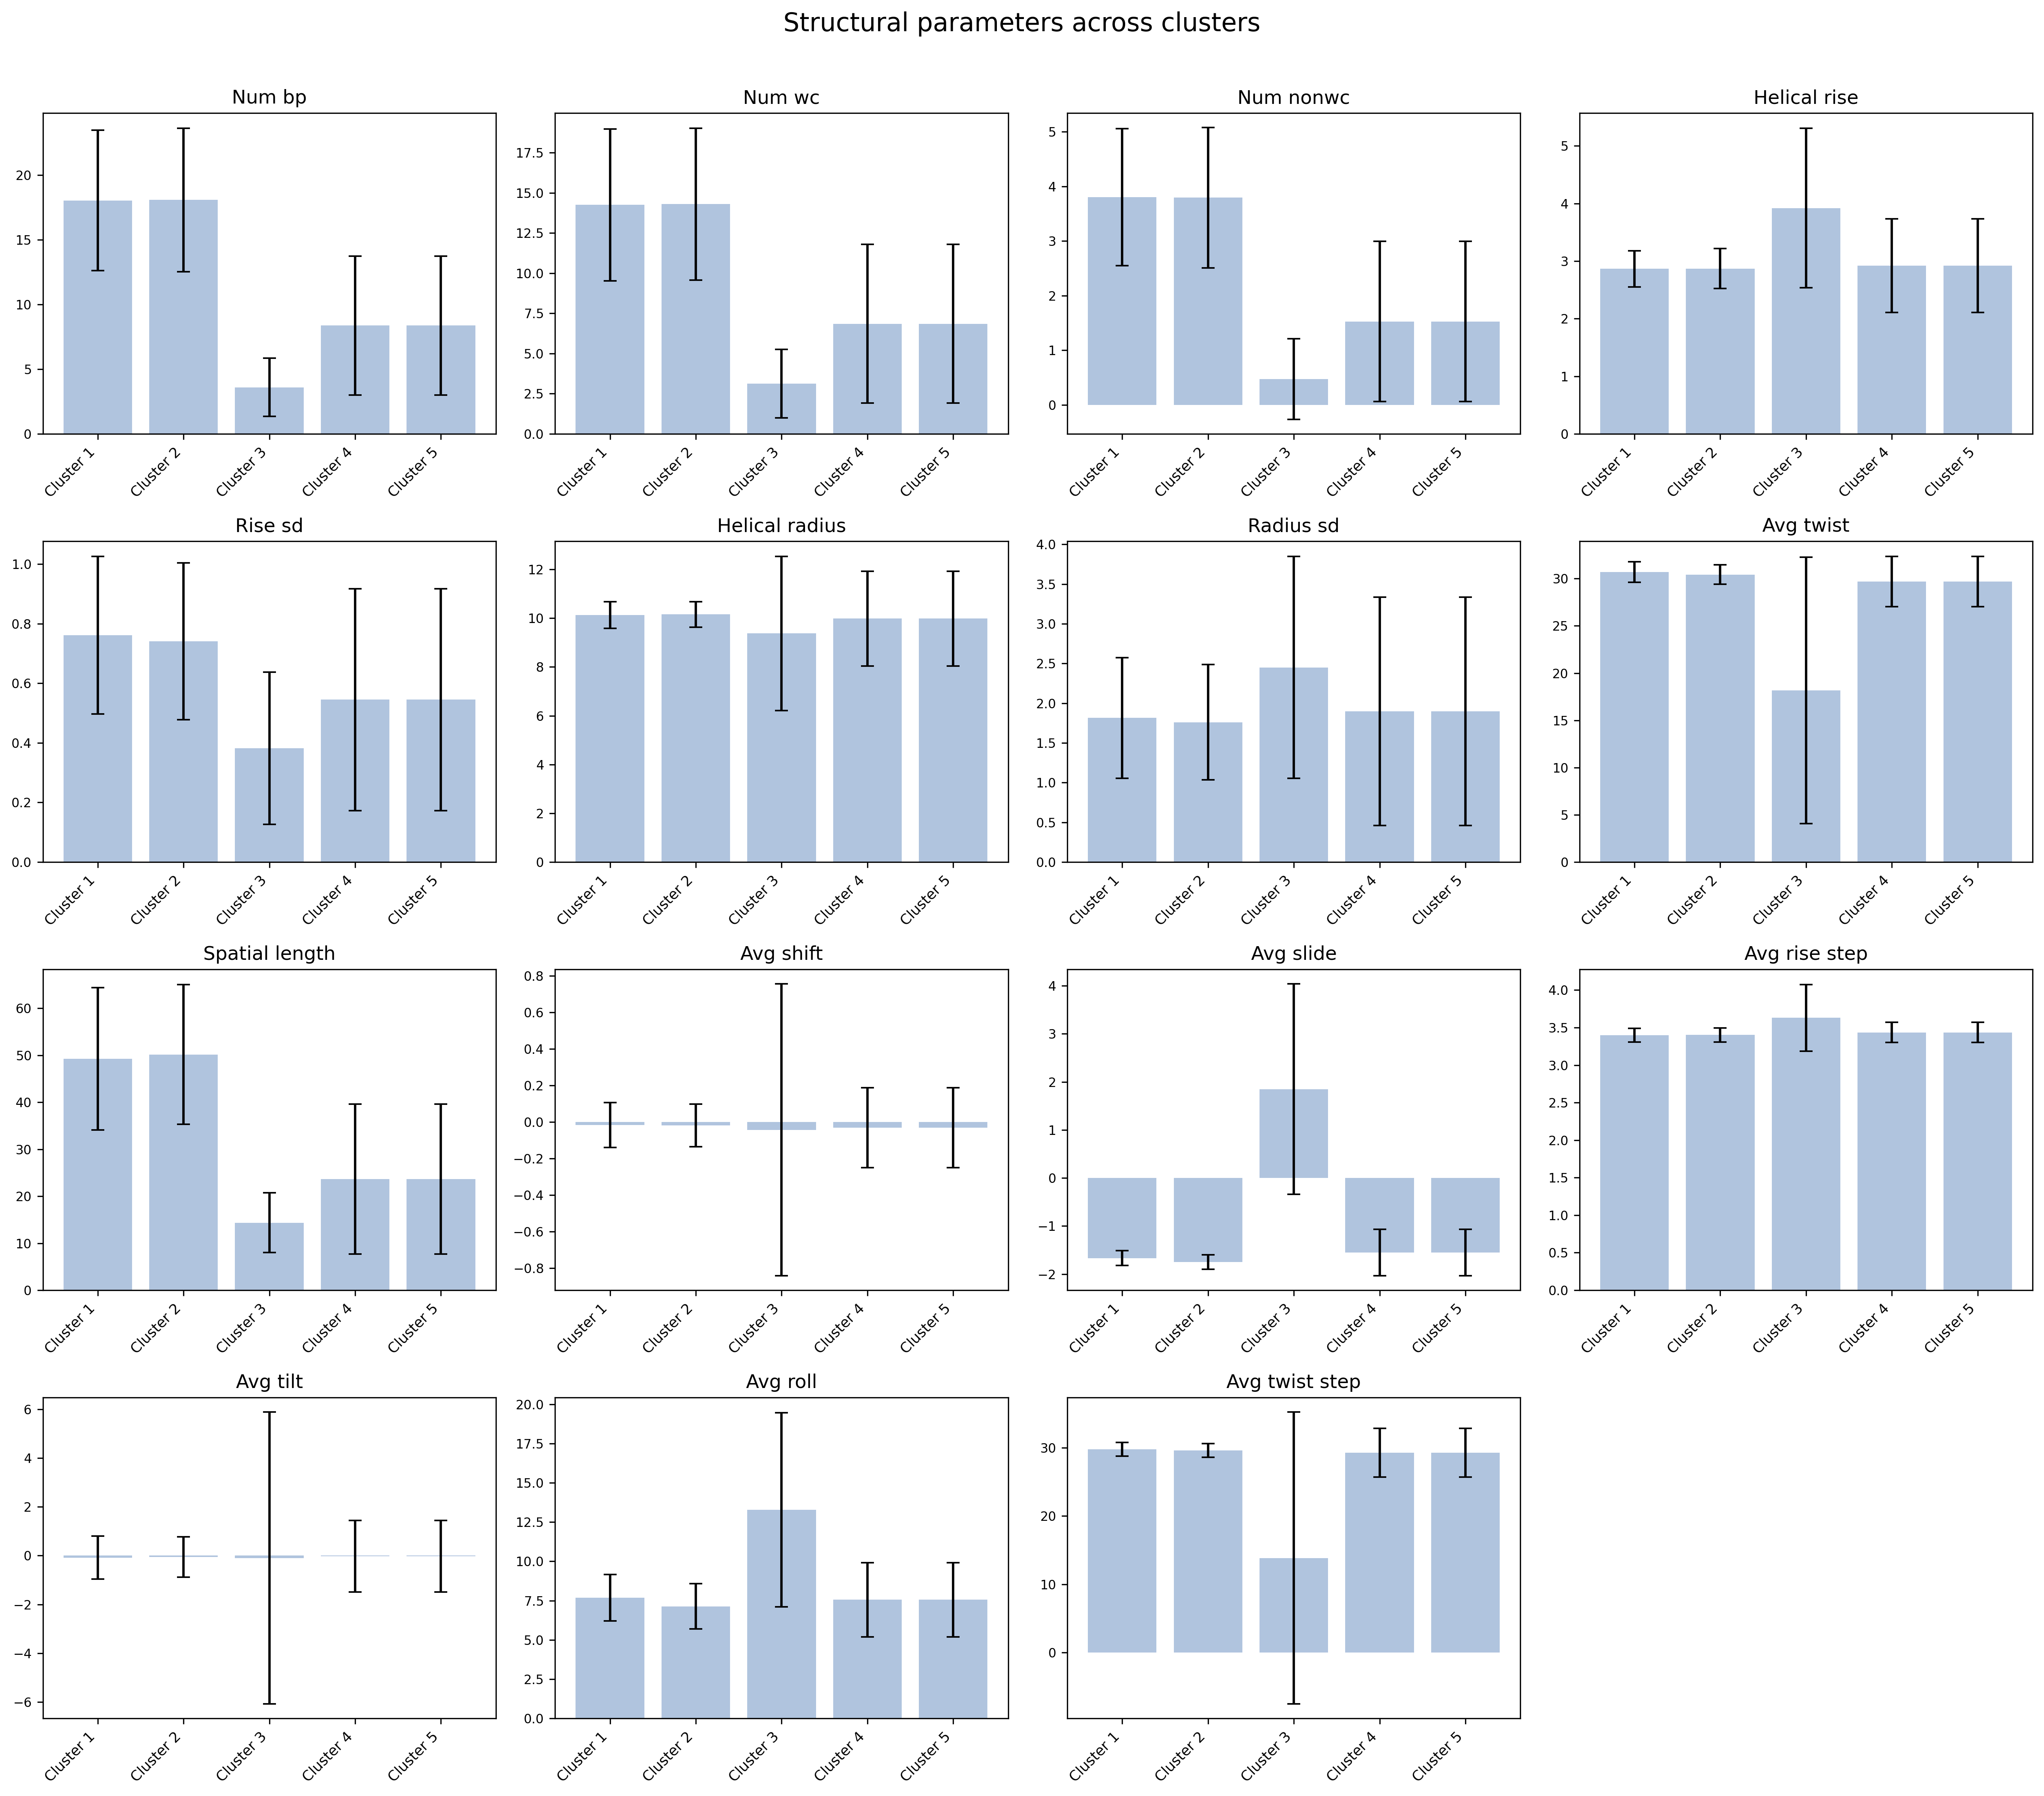

In [29]:
# Define all parameters to plot
params = [
    "num_bp", "num_WC", "num_nonWC",
    "helical_rise", "rise_sd", "helical_radius", "radius_sd",
    "avg_twist", "spatial_length",
    "avg_shift", "avg_slide", "avg_rise_step",
    "avg_tilt", "avg_roll", "avg_twist_step"
]

cluster_names = list(cluster_dfs.keys())

# Layout: determine grid size automatically
n_params = len(params)
ncols = 4
nrows = int(np.ceil(n_params / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(4.5 * ncols, 4 * nrows), dpi=300)
axes = axes.flatten()

# Plot each parameter
for i, param in enumerate(params):
    ax = axes[i]
    means = [df[param].mean() for df in cluster_dfs.values()]
    stds = [df[param].std() for df in cluster_dfs.values()]

    ax.bar(cluster_names, means, yerr=stds, capsize=4, color="lightsteelblue")
    ax.set_title(param.replace("_", " ").capitalize())
    ax.set_xticks(range(len(cluster_names)))
    ax.set_xticklabels(cluster_names, rotation=45, ha="right", fontsize=9)
    ax.tick_params(axis='y', labelsize=8)

# Remove unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Structural parameters across clusters", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [30]:
# Step 1: Merge
cluster_1 = pd.concat([df1, df2], ignore_index=True)
cluster_2 = df3.copy()
cluster_3 = pd.concat([df4, df5], ignore_index=True)

merged_clusters = {
    "1+2": cluster_1,
    "3": cluster_2,
    "4+5": cluster_3,
}

# Step 2: Parameters to analyze
params = [
    "num_bp", "num_WC", "num_nonWC",
    "helical_rise", "rise_sd", "helical_radius", "radius_sd",
    "avg_twist", "spatial_length",
    "avg_shift", "avg_slide", "avg_rise_step",
    "avg_tilt", "avg_roll", "avg_twist_step"
]

# Step 3: Compute summary table
summary_means = pd.DataFrame({name: df[params].mean() for name, df in merged_clusters.items()})
summary_stds = pd.DataFrame({name: df[params].std() for name, df in merged_clusters.items()})

In [31]:
# Combine all rows across clusters to get global min/max for each parameter
all_combined = pd.concat([cluster_1[params], cluster_2[params], cluster_3[params]], ignore_index=True)

# Compute global min/max per parameter
param_min = all_combined.min()
param_max = all_combined.max()
param_range = param_max - param_min
param_range[param_range == 0] = 1  # Avoid division by zero

In [32]:
# Ensure values are numpy arrays before reshaping
range_array = param_range.values.reshape(-1, 1)
min_array = param_min.values.reshape(-1, 1)

# Normalize using correct broadcasting
means_norm = (summary_means - min_array) / range_array
stds_norm = summary_stds / range_array

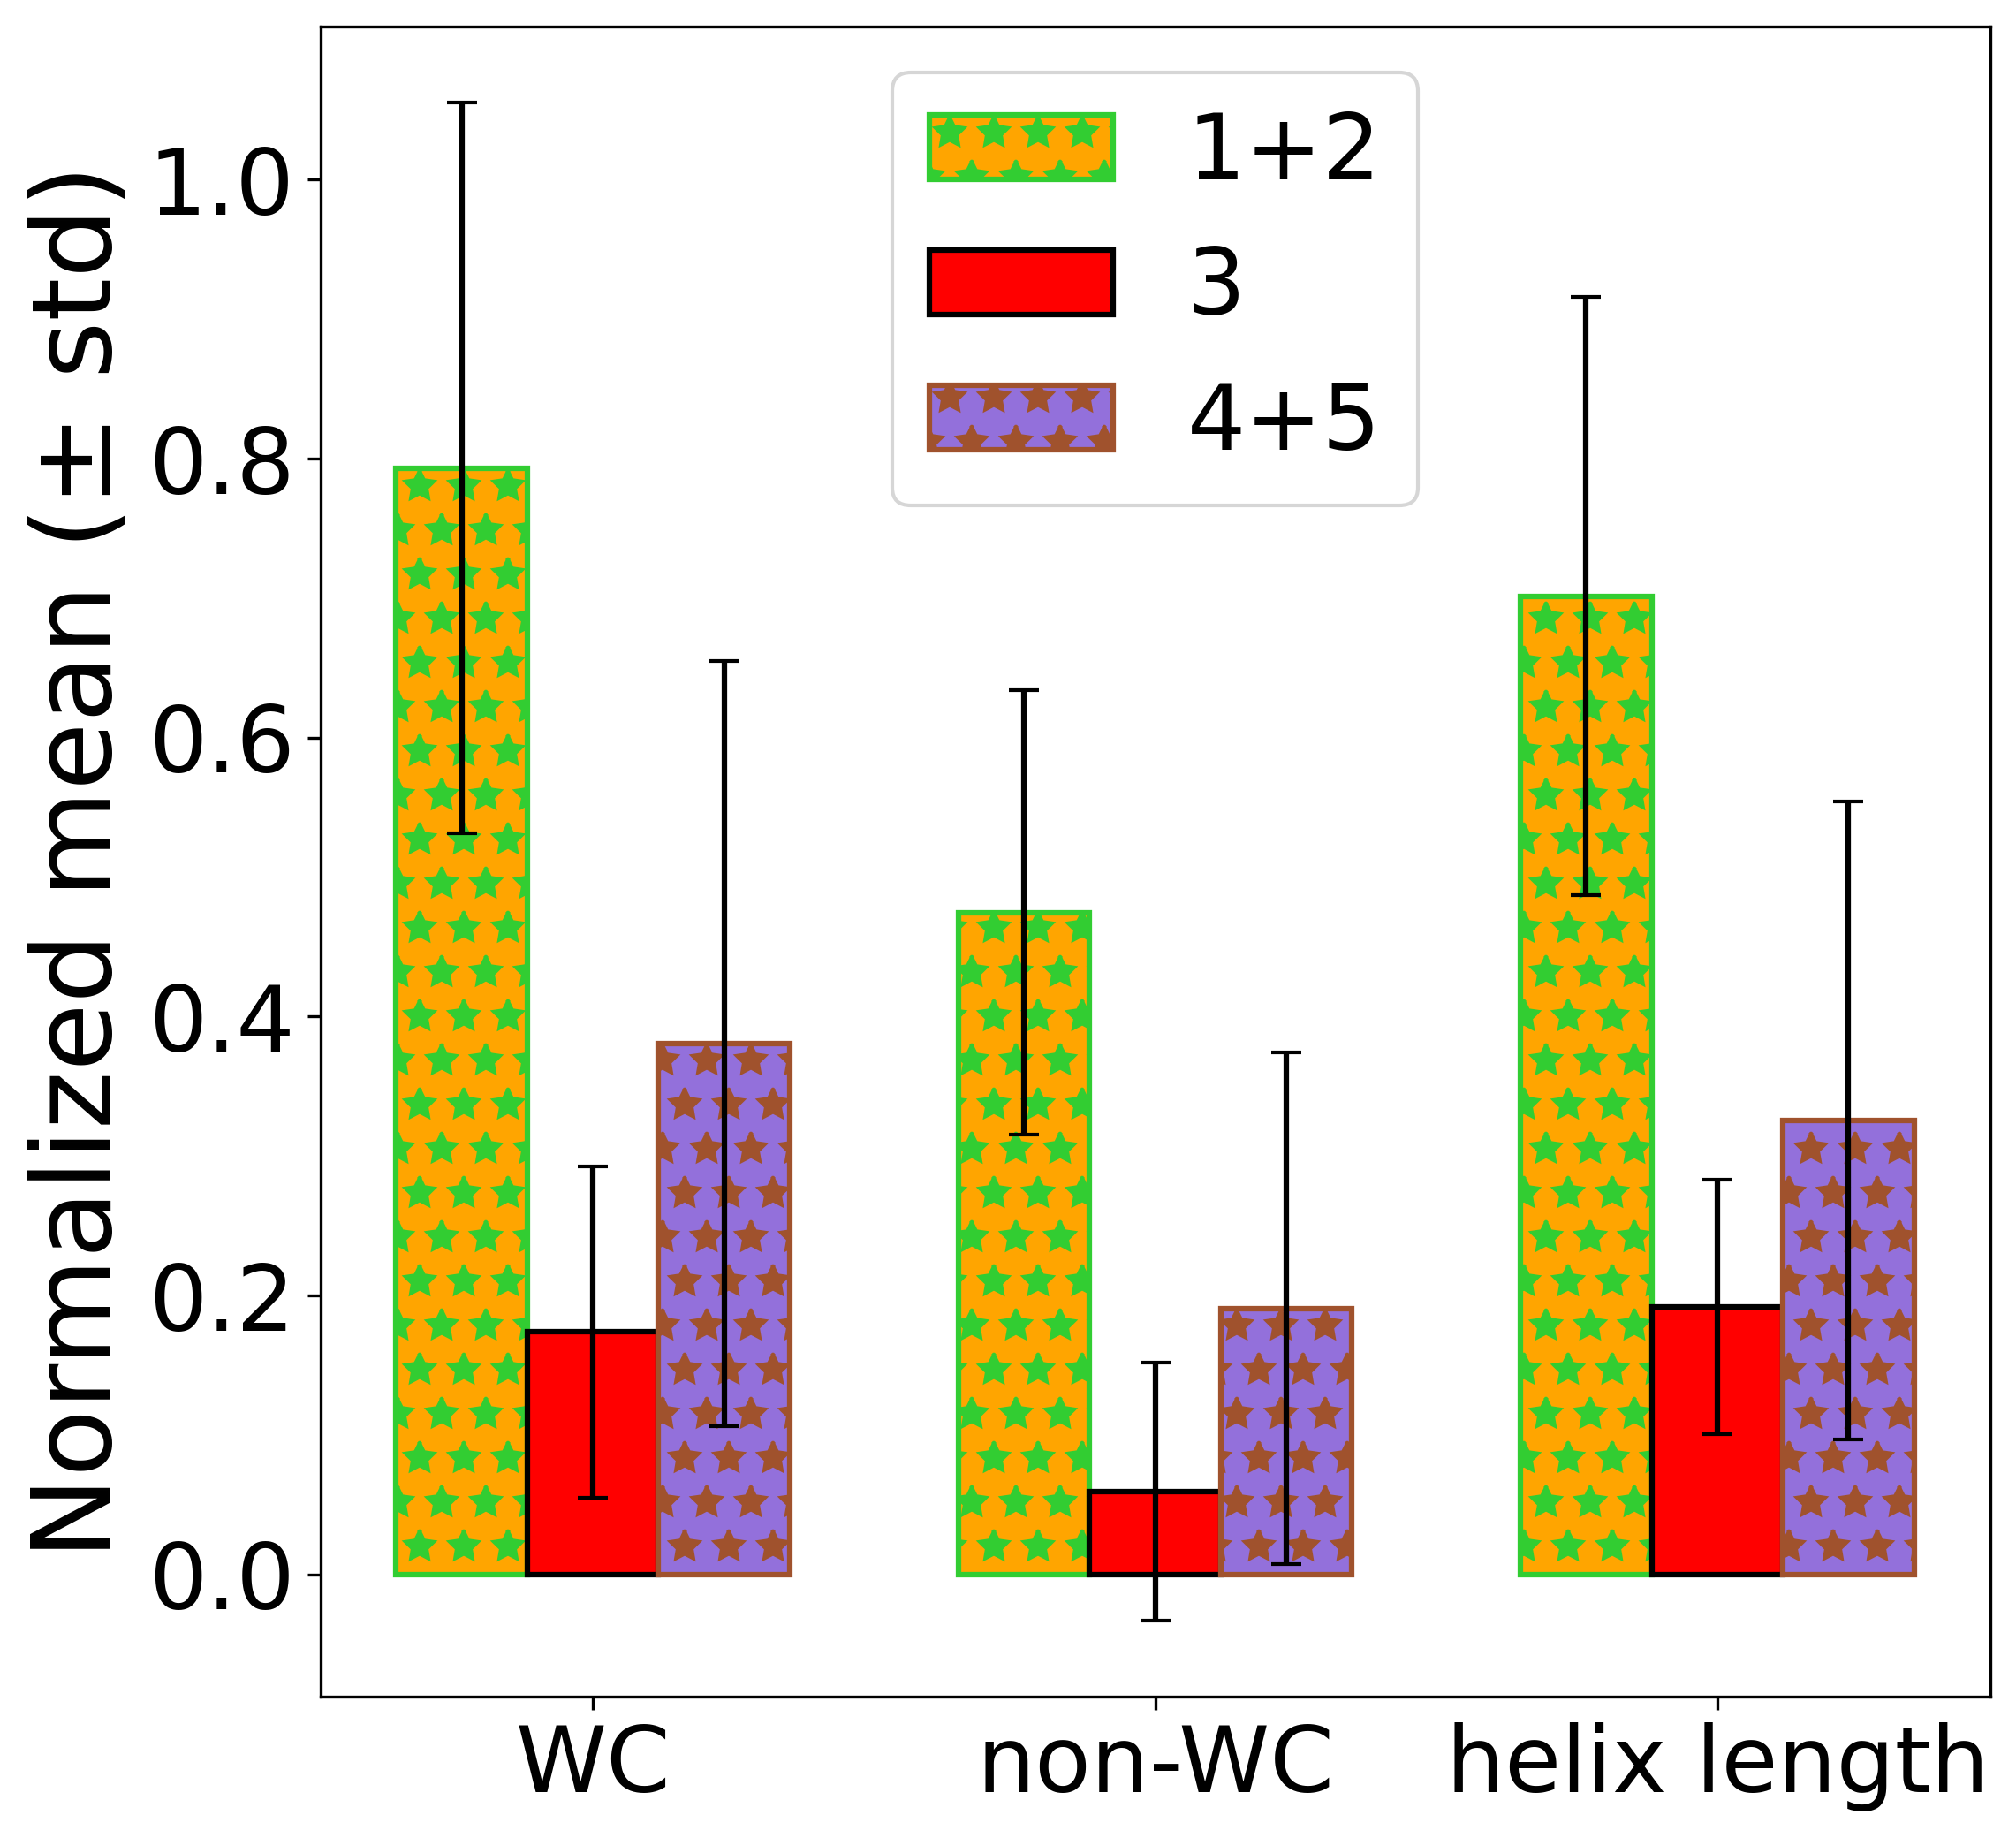

In [33]:
# Basic setup
selected_params = {
    "num_WC": "WC",
    "num_nonWC": "non-WC",
    "spatial_length": "helix length"
}
sel_keys = list(selected_params.keys())
sel_labels = list(selected_params.values())

means_sel = means_norm.loc[sel_keys]
stds_sel = stds_norm.loc[sel_keys]

# Cluster visual styles
cluster_styles = {
    "1+2": {"facecolor": "orange", "hatchcolor": "limegreen", "hatch": "*"},
    "3":   {"facecolor": "r",      "hatchcolor": None,        "hatch": None},
    "4+5": {"facecolor": "mediumpurple", "hatchcolor": "sienna", "hatch": "*"},
}

fig = plt.figure(figsize=(9, 9), dpi=300, facecolor='w')
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.85, top=0.85, hspace=0.05)
ax = fig.add_subplot(111)

# Control width to avoid overlap
n_clusters = len(means_sel.columns)
total_group_width = 0.7  # max total width for group of bars
width = total_group_width / n_clusters  # per-bar width
x = np.arange(len(sel_keys))  # one x per descriptor

# Draw bars
for i, name in enumerate(means_sel.columns):
    style = cluster_styles[name]
    for j, param in enumerate(sel_keys):
        xpos = x[j] - total_group_width / 2 + i * width + width / 2
        ax.bar(xpos,
               means_sel.loc[param, name],
               yerr=stds_sel.loc[param, name],
               capsize=4,
               width=width,
               color=style["facecolor"],
               edgecolor=style["hatchcolor"] if style["hatchcolor"] else 'black',
               hatch=style["hatch"],
               linewidth=1.5,
               label=name if j == 0 else None)

# Axis and label styling
ax.set_xticks(x)
ax.set_xticklabels(sel_labels, fontsize=30)
ax.set_ylabel("Normalized mean (± std)", fontsize=30)
ax.tick_params(axis='y', labelsize=25)
ax.tick_params(axis='x', labelsize=25)
ax.legend(fontsize=25)


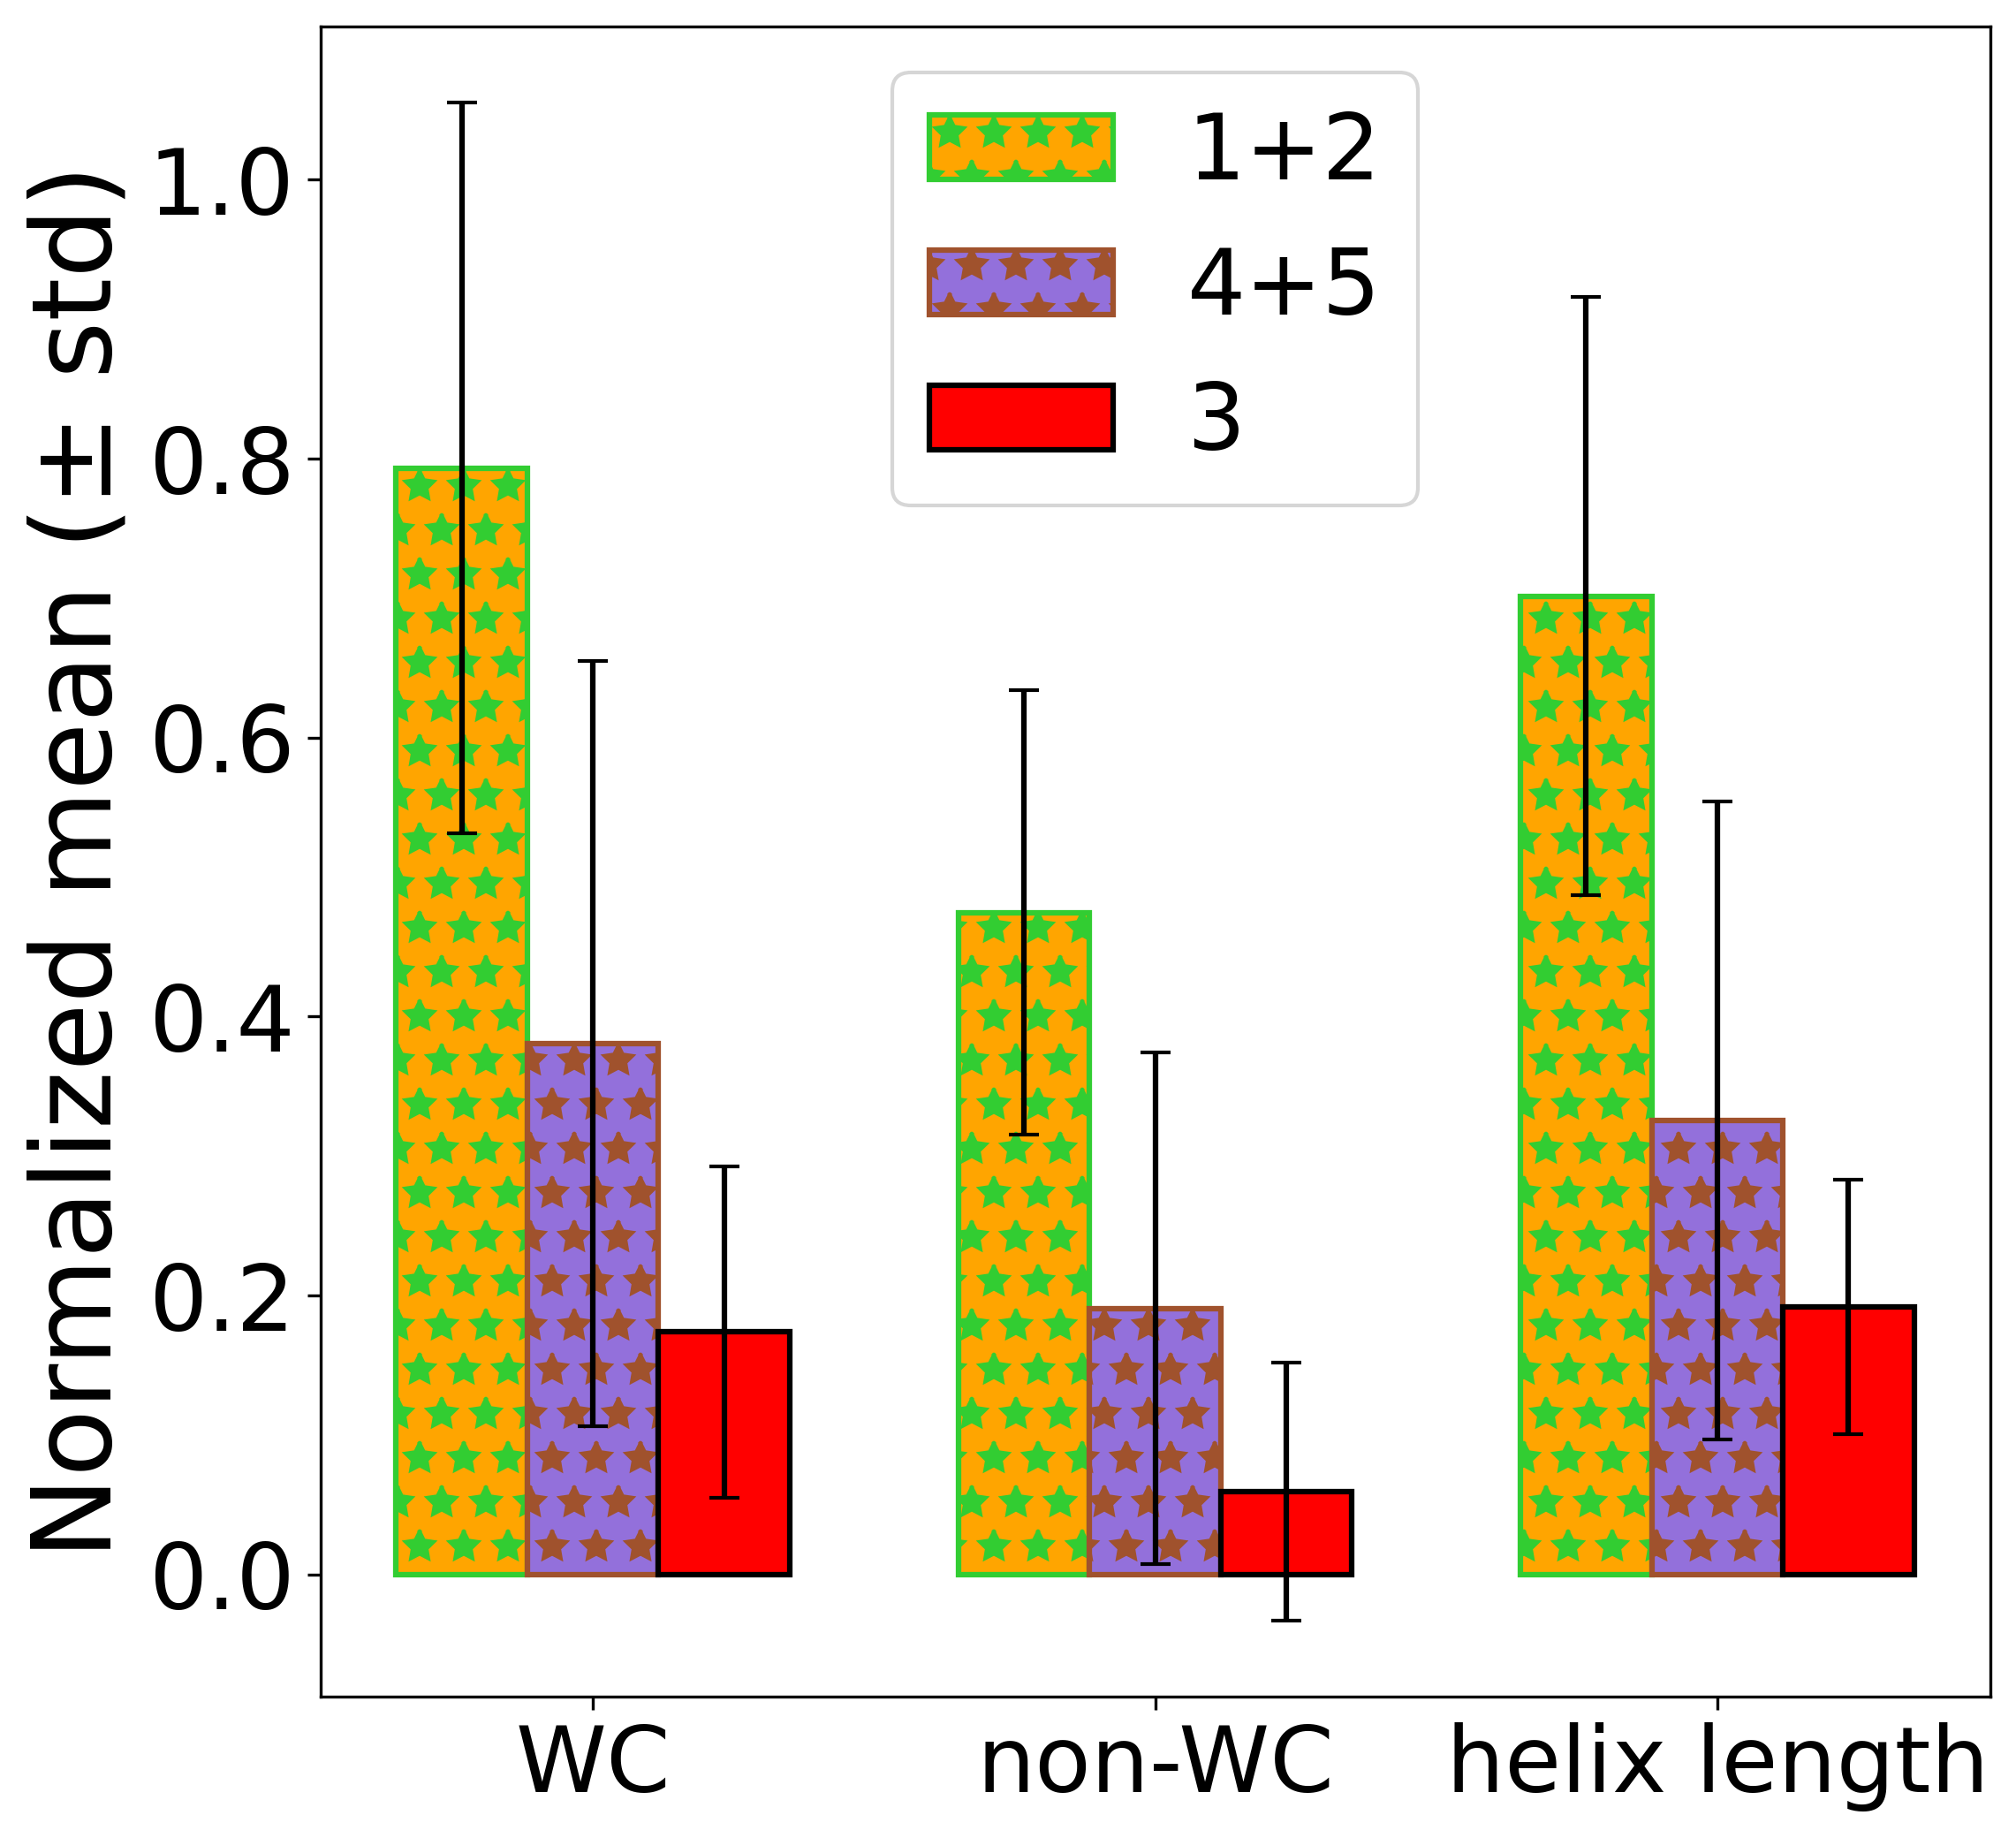

In [36]:
# Basic setup
selected_params = {
    "num_WC": "WC",
    "num_nonWC": "non-WC",
    "spatial_length": "helix length"
}
sel_keys = list(selected_params.keys())
sel_labels = list(selected_params.values())

means_sel = means_norm.loc[sel_keys]
stds_sel = stds_norm.loc[sel_keys]

# Cluster visual styles
cluster_styles = {
    "1+2": {"facecolor": "orange", "hatchcolor": "limegreen", "hatch": "*"},
    "3":   {"facecolor": "r", "hatchcolor": None, "hatch": None},
    "4+5": {"facecolor": "mediumpurple", "hatchcolor": "sienna", "hatch": "*"},
}

# Desired cluster plotting order
cluster_order = ["1+2", "4+5", "3"]

# Reorder data
means_sel = means_sel[cluster_order]
stds_sel = stds_sel[cluster_order]

# Figure setup
fig = plt.figure(figsize=(9, 9), dpi=300, facecolor='w')
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.85, top=0.85, hspace=0.05)
ax = fig.add_subplot(111)

# Control width to avoid overlap
n_clusters = len(means_sel.columns)
total_group_width = 0.7  # max total width for group of bars
width = total_group_width / n_clusters  # per-bar width
x = np.arange(len(sel_keys))  # one x per descriptor

# Draw bars
for i, name in enumerate(means_sel.columns):
    style = cluster_styles[name]
    for j, param in enumerate(sel_keys):
        xpos = x[j] - total_group_width / 2 + i * width + width / 2
        ax.bar(
            xpos,
            means_sel.loc[param, name],
            yerr=stds_sel.loc[param, name],
            capsize=4,
            width=width,
            color=style["facecolor"],
            edgecolor=style["hatchcolor"] if style["hatchcolor"] else 'black',
            hatch=style["hatch"],
            linewidth=1.5,
            label=name if j == 0 else None
        )

# Axis and label styling
ax.set_xticks(x)
ax.set_xticklabels(sel_labels, fontsize=30)
ax.set_ylabel("Normalized mean (± std)", fontsize=30)
ax.tick_params(axis='y', labelsize=25)
ax.tick_params(axis='x', labelsize=25)
ax.legend(fontsize=25)
